<a href="https://colab.research.google.com/github/SafnasKaldeen/5G-Energy-Prediction/blob/main/Final_DCGAN_on_MNIST_200549T.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### References
[Official PyTorch DCGAN tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

[MNIST dataset on torchvision](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html)



### Imports

In [2]:
#%matplotlib inline
import argparse
import os
import random
import pickle
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, display, clear_output
from PIL import Image
import ipywidgets as widgets

manualSeed = 69
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [3]:
!rm -rf data

### Inputs

In [4]:
batch_size = 64
image_size = 28
nc = 1
nz = 100
ngf = 64
ndf = 64
num_epochs = 150
lr = 3e-4
beta1 = 0.5
ngpu = 1

### Download and load the dataset

In [5]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
%%capture
dataset = dset.MNIST(root='./data', train=True, download=True, transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [7]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

### Plotting some training images

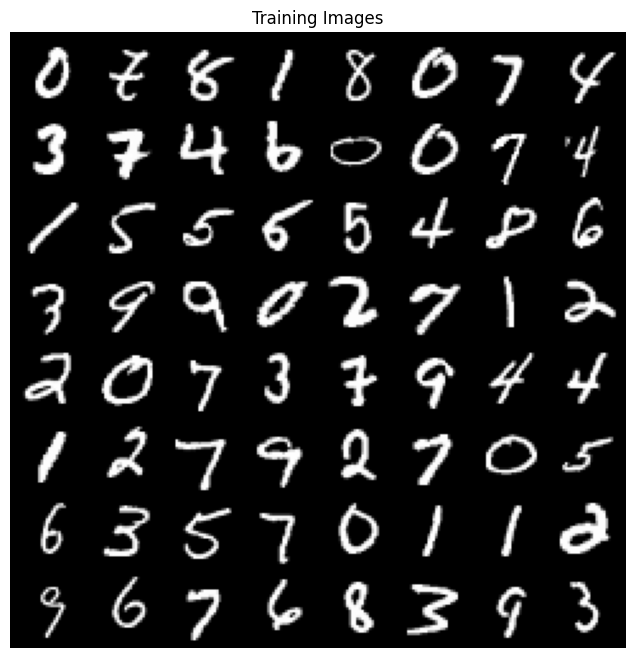

In [8]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:100], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

### Weight initialization

In [9]:
# Initializing weights with mean=0, sd=0.02 according to DCGAN paper
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Initialization of the Generator

In [10]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf, nc, 1, 1, 2, bias=False),
            nn.Tanh()
          )

    def forward(self, input):
        return self.main(input)

In [11]:
G = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    G = nn.DataParallel(G, list(range(ngpu)))

G.apply(weights_init)

print(G)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    (13): Tanh()
  )
)


### Initialization of the Discriminator

In [12]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [13]:
D = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    D = nn.DataParallel(D, list(range(ngpu)))

D.apply(weights_init)

print(D)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


### Loss functions and Optimizers

In [14]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

### Training Loop

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        D.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = D(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = G(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = D(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on **fixed_noise**
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

[0/150][0/938]	Loss_D: 1.1578	Loss_G: 1.8706	D(x): 0.6124	D(G(z)): 0.4497 / 0.1693
[0/150][50/938]	Loss_D: 0.3161	Loss_G: 5.5893	D(x): 0.8204	D(G(z)): 0.0756 / 0.0066
[0/150][100/938]	Loss_D: 0.7948	Loss_G: 2.2065	D(x): 0.5246	D(G(z)): 0.0435 / 0.1343
[0/150][150/938]	Loss_D: 1.3651	Loss_G: 6.1171	D(x): 0.9737	D(G(z)): 0.7065 / 0.0032
[0/150][200/938]	Loss_D: 0.2945	Loss_G: 2.7584	D(x): 0.8681	D(G(z)): 0.1335 / 0.0781
[0/150][250/938]	Loss_D: 0.5055	Loss_G: 2.4937	D(x): 0.7571	D(G(z)): 0.1724 / 0.1017
[0/150][300/938]	Loss_D: 0.5009	Loss_G: 4.3602	D(x): 0.9519	D(G(z)): 0.3408 / 0.0158
[0/150][350/938]	Loss_D: 0.7470	Loss_G: 3.5768	D(x): 0.9026	D(G(z)): 0.4407 / 0.0349
[0/150][400/938]	Loss_D: 0.7808	Loss_G: 4.1446	D(x): 0.9227	D(G(z)): 0.4811 / 0.0211
[0/150][450/938]	Loss_D: 0.7432	Loss_G: 2.1511	D(x): 0.7794	D(G(z)): 0.3504 / 0.1405
[0/150][500/938]	Loss_D: 0.6437	Loss_G: 1.7638	D(x): 0.7371	D(G(z)): 0.2607 / 0.1959
[0/150][550/938]	Loss_D: 0.7216	Loss_G: 1.4082	D(x): 0.6751	D(G(z)):

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

### Saving the models

In [ ]:
with open('G.pkl', 'wb') as f:
    pickle.dump(G.state_dict(), f)

with open('D.pkl', 'wb') as f:
    pickle.dump(D.state_dict(), f)

### Loading the model

In [ ]:
!pwd
!rm -rf Fake_Digits/

In [ ]:
G = Generator(ngpu).to(device)
D = Discriminator(ngpu).to(device)

with open('G.pkl', 'rb') as f:
    G_state_dict = pickle.load(f)
    G.load_state_dict(G_state_dict)

# with open('D.pkl', 'rb') as f:
#     D_state_dict = pickle.load(f)
#     D.load_state_dict(D_state_dict)

### Annotating and creating the fake dataset

In [ ]:
G = G.eval()

In [ ]:
buttons = [widgets.Button(description=str(i)) for i in range(10)]
skip_button = widgets.Button(description="Skip")
output = widgets.Output()

button_grid = widgets.GridBox(
    buttons + [skip_button],
    layout=widgets.Layout(
        grid_template_columns="repeat(5, 100px)",  # 5 buttons per row
        grid_gap="10px 10px",
        justify_content="center"
    )
)

display(button_grid, output)
index = 0

save_path = "./Fake_Digits"

os.makedirs(save_path, exist_ok=True)

In [ ]:
def save_image_and_vector(label, index, image, latent_vector):
    os.makedirs(f"{save_path}/{label}", exist_ok=True)
    Image.fromarray(image).save(f"{save_path}/{label}/{index}.png")

    latent_vector_str = np.array2string(latent_vector, separator=',', formatter={'float_kind': lambda x: "%.8f" % x})
    latent_vector_str = latent_vector_str.replace('\n', '')
    with open(f"{save_path}/{label}/{index}.txt", "w") as f:
        f.write(latent_vector_str)

def on_button_clicked(label):
    global latent_vector, current_image, index
    save_image_and_vector(label, index, current_image, latent_vector)
    index += 1
    with output:
        clear_output(wait=True)
        print(f"Saved as {save_path}/{label}/{index}.png and {save_path}/{label}/{index}.txt")
    display_next_image()

def on_skip_clicked(b):
    with output:
        clear_output(wait=True)
        print("Skipping saving.")
    display_next_image()

def display_next_image():
    global current_image, latent_vector
    with torch.no_grad():
        noise = torch.randn(1, nz, 1, 1, device=device)
        latent_vector = noise.cpu().numpy().flatten()
        current_image = G(noise).detach().cpu().squeeze().mul(127.5).add(127.5).numpy().astype(np.uint8) # Denormalize

        with output:
            clear_output(wait=True)
            plt.imshow(current_image, cmap='gray')
            plt.axis('off')
            plt.show()

for i, button in enumerate(buttons):
    button.on_click(lambda b, i=i: on_button_clicked(str(i)))
skip_button.on_click(on_skip_clicked)

display_next_image()


In [ ]:
!zip -r Fake_Digits.zip Fake_Digits/